**Apogee Data Simple VAE Testing**

In [16]:
# Basic imports
import torch
import torch.nn as nn
import numpy as np
import pandas as pd

from torch.optim import Adam

from torchvision.datasets import MNIST
import torchvision.transforms as transforms
from torch.utils.data import DataLoader

from tqdm import tqdm
from torchvision.utils import save_image, make_grid

from astropy.io import fits

from matplotlib import pyplot as plt

**Hyperparameters**

In [2]:
# Hyperparameters

dataset_path = '~/datasets'

cuda = True
DEVICE = torch.device("cuda" if cuda else "cpu")

batch_size = 100

# Initial input dimension
x_dim  = 784
hidden_dim = 400
latent_dim = 200

# Learning rate
lr = 1e-3

# Num epochs
epochs = 30

**Process and Load Data**

In [43]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [47]:
print("\n ********************** Opening FITS files from drive **********************")

star_hdus = fits.open('/content/drive/MyDrive/2021-2022 Engsci Thesis/allStar-r12-l33.fits')
astroNN_hdus = fits.open('/content/drive/MyDrive/2021-2022 Engsci Thesis/apogee_astroNN-DR16-v1.fits')
star_spec = fits.open('/content/drive/MyDrive/2021-2022 Engsci Thesis/contspec_dr16_final.fits')

star = star_hdus[1].data
star_astroNN = astroNN_hdus[1].data
star_spectra = star_spec[0].data

star_hdus.close()
astroNN_hdus.close()
star_spec.close()

print("Number of spectra: ", len(star))


 ********************** Opening FITS files from drive **********************
Number of spectra:  473307


In [48]:
def starInfoDebug():
  for i in range(10):
      # Title information
      print("\n**************** Looking at index ", i, " ****************")
      print("APSTAR ID: ", star['apstar_id'][i],\
          "\nTARGET_ID: ", star['target_id'][i],\
              "\nASPCAP_ID: ", star['aspcap_id'][i])
      
      print("\nBasic Stats:")
      print("SNR: ", star['snr'][i])
      print("Effective Temp (K) \t ASPCAP: ", star['teff_spec'][i], 'AstroNN:', star_astroNN['TEFF'][i])
      print("Surface G (log(cm/s^2) \t ASPCAP: ", star['logg_spec'][i], 'AstroNN:', star_astroNN['LOGG'][i])

      #j = ind[i]
      j = i

      plt.subplot(5, 2, j+1)
      plt.title(star['aspcap_id'][i])
      plt.xlabel('Wavelength')
      plt.ylabel('Relative Flux')
      # 7514 data points for each spectra
      plt.plot(star_spectra[j])

      spectra_df = pd.DataFrame(star_spectra[j])
      # Actual input data
      print("\nInput dataframe:")
      print(spectra_df)

      #print(len(star_spectra[j]))
      #plt.legend([star['aspcap_id'][i]])
      #plt.show()

      # Abundances, other info
      print("\nAbundances, additional info (ASPCAP):")
      print(star['ra'][j], star['dec'][j], star['glon'][j], star['glat'][j],\
          star['vhelio_avg'][j], star['vscatter'][j],\
          star['teff'][j], star['teff_err'][j],\
          star['logg'][j], star['logg_err'][j],\
          star['m_h'][j], star['m_h_err'][j],\
          star['alpha_m'][j], star['alpha_m_err'][j],\
          star['c_fe'][j], star['c_fe_err'][j],\
          star['cI_fe'][j], star['cI_fe_err'][j],\
          star['n_fe'][j], star['n_fe_err'][j],\
          star['o_fe'][j], star['o_fe_err'][j],\
          star['na_fe'][j], star['na_fe_err'][j],\
          star['mg_fe'][j], star['mg_fe_err'][j],\
          star['al_fe'][j], star['al_fe_err'][j],\
          star['si_fe'][j], star['si_fe_err'][j],\
          star['p_fe'][j], star['p_fe_err'][j],\
          star['s_fe'][j], star['s_fe_err'][j],\
          star['k_fe'][j], star['k_fe_err'][j],\
          star['ca_fe'][j], star['ca_fe_err'][j],\
          star['ti_fe'][j], star['ti_fe_err'][j],\
          star['v_fe'][j], star['v_fe_err'][j],\
          star['cr_fe'][j], star['cr_fe_err'][j],\
          star['mn_fe'][j], star['mn_fe_err'][j],\
          star['fe_h'][j], star['fe_h_err'][j],\
          star['co_fe'][j], star['co_fe_err'][j],\
          star['ni_fe'][j], star['ni_fe_err'][j],\
          star['cu_fe'][j], star['cu_fe_err'][j],\
          star['ge_fe'][j], star['ge_fe_err'][j],\
          star['rb_fe'][j], star['rb_fe_err'][j],\
          star['aspcapflags'][j], star['starflags'][j])

    plt.subplots_adjust(hspace=1)
    #plt.tight_layout()
    plt.show()

In [3]:
mnist_transform = transforms.Compose([
        transforms.ToTensor(),
])

kwargs = {'num_workers': 1, 'pin_memory': True} 

# train_dataset_mnist = MNIST(dataset_path, transform=mnist_transform, train=True, download=True)
# test_dataset_mnist  = MNIST(dataset_path, transform=mnist_transform, train=False, download=True)


train_loader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True, **kwargs)
test_loader  = DataLoader(dataset=test_dataset,  batch_size=batch_size, shuffle=False, **kwargs)

  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting /root/datasets/MNIST/raw/train-images-idx3-ubyte.gz to /root/datasets/MNIST/raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting /root/datasets/MNIST/raw/train-labels-idx1-ubyte.gz to /root/datasets/MNIST/raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting /root/datasets/MNIST/raw/t10k-images-idx3-ubyte.gz to /root/datasets/MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting /root/datasets/MNIST/raw/t10k-labels-idx1-ubyte.gz to /root/datasets/MNIST/raw



In [55]:
print(len(train_dataset[0][0][0]))

28


Implement Simple VAE

In [5]:
"""
    A simple implementation of Gaussian MLP Encoder and Decoder
"""

class Encoder(nn.Module):
    
    def __init__(self, input_dim, hidden_dim, latent_dim):
        super(Encoder, self).__init__()

        self.FC_input = nn.Linear(input_dim, hidden_dim)
        self.FC_input2 = nn.Linear(hidden_dim, hidden_dim)
        self.FC_mean  = nn.Linear(hidden_dim, latent_dim)
        self.FC_var   = nn.Linear (hidden_dim, latent_dim)
        
        self.LeakyReLU = nn.LeakyReLU(0.2)
        
        self.training = True
        
    def forward(self, x):
        h_       = self.LeakyReLU(self.FC_input(x))
        h_       = self.LeakyReLU(self.FC_input2(h_))
        mean     = self.FC_mean(h_)
        log_var  = self.FC_var(h_)                     # encoder produces mean and log of variance 
                                                       #             (i.e., parateters of simple tractable normal distribution "q"
        
        return mean, log_var

In [6]:
class Decoder(nn.Module):
    def __init__(self, latent_dim, hidden_dim, output_dim):
        super(Decoder, self).__init__()
        self.FC_hidden = nn.Linear(latent_dim, hidden_dim)
        self.FC_hidden2 = nn.Linear(hidden_dim, hidden_dim)
        self.FC_output = nn.Linear(hidden_dim, output_dim)
        
        self.LeakyReLU = nn.LeakyReLU(0.2)
        
    def forward(self, x):
        h     = self.LeakyReLU(self.FC_hidden(x))
        h     = self.LeakyReLU(self.FC_hidden2(h))
        
        x_hat = torch.sigmoid(self.FC_output(h))
        return x_hat
        

In [7]:
class Model(nn.Module):
    def __init__(self, Encoder, Decoder):
        super(Model, self).__init__()
        self.Encoder = Encoder
        self.Decoder = Decoder
        
    def reparameterization(self, mean, var):
        epsilon = torch.randn_like(var).to(DEVICE)        # sampling epsilon        
        z = mean + var*epsilon                          # reparameterization trick
        return z
        
                
    def forward(self, x):
        mean, log_var = self.Encoder(x)
        z = self.reparameterization(mean, torch.exp(0.5 * log_var)) # takes exponential function (log var -> var)
        x_hat            = self.Decoder(z)
        
        return x_hat, mean, log_var

In [8]:
encoder = Encoder(input_dim=x_dim, hidden_dim=hidden_dim, latent_dim=latent_dim)
decoder = Decoder(latent_dim=latent_dim, hidden_dim = hidden_dim, output_dim = x_dim)

model = Model(Encoder=encoder, Decoder=decoder).to(DEVICE)

In [9]:
BCE_loss = nn.BCELoss()

def loss_function(x, x_hat, mean, log_var):
    reproduction_loss = nn.functional.binary_cross_entropy(x_hat, x, reduction='sum')
    KLD      = - 0.5 * torch.sum(1+ log_var - mean.pow(2) - log_var.exp())

    return reproduction_loss + KLD


optimizer = Adam(model.parameters(), lr=lr)

In [10]:
print("Start training VAE...")
model.train()

for epoch in range(epochs):
    overall_loss = 0
    for batch_idx, (x, _) in enumerate(train_loader):
        x = x.view(batch_size, x_dim)
        x = x.to(DEVICE)

        optimizer.zero_grad()

        x_hat, mean, log_var = model(x)
        loss = loss_function(x, x_hat, mean, log_var)
        
        overall_loss += loss.item()
        
        loss.backward()
        optimizer.step()
        
    print("\tEpoch", epoch + 1, "complete!", "\tAverage Loss: ", overall_loss / (batch_idx*batch_size))
    
print("Finish!!")

Start training VAE...
	Epoch 1 complete! 	Average Loss:  175.92844790145034
	Epoch 2 complete! 	Average Loss:  130.05690043301337
	Epoch 3 complete! 	Average Loss:  117.39978140651085
	Epoch 4 complete! 	Average Loss:  113.31106248043615
	Epoch 5 complete! 	Average Loss:  110.55567170870722
	Epoch 6 complete! 	Average Loss:  108.6348239742018
	Epoch 7 complete! 	Average Loss:  107.24454174926962
	Epoch 8 complete! 	Average Loss:  106.1592255484401
	Epoch 9 complete! 	Average Loss:  105.31434254030154
	Epoch 10 complete! 	Average Loss:  104.71082003534536
	Epoch 11 complete! 	Average Loss:  104.14253395959412
	Epoch 12 complete! 	Average Loss:  103.79725626695534
	Epoch 13 complete! 	Average Loss:  103.27564585181031
	Epoch 14 complete! 	Average Loss:  102.96115930522224
	Epoch 15 complete! 	Average Loss:  102.68860287979966
	Epoch 16 complete! 	Average Loss:  102.37059609440213
	Epoch 17 complete! 	Average Loss:  102.20631232718594
	Epoch 18 complete! 	Average Loss:  101.9190892861801


In [11]:
model.eval()

with torch.no_grad():
    for batch_idx, (x, _) in enumerate(tqdm(test_loader)):
        x = x.view(batch_size, x_dim)
        x = x.to(DEVICE)
        
        x_hat, _, _ = model(x)


        break

  0%|          | 0/100 [00:00<?, ?it/s]


In [41]:
def show_image(x, idx):
    x = x.view(batch_size, 28, 28)

    fig = plt.figure()
    plt.imshow(x[idx].cpu().numpy())

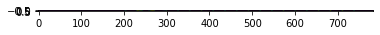

In [40]:
# Ground truth data
show_image(x, idx=0)

In [42]:
print(x[0])

tensor([0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 

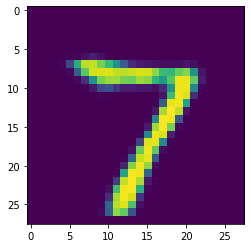

In [15]:
# Generated Data
show_image(x_hat, idx=0)